Importation des librairies

In [104]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns



Importation des jeux de données

In [105]:
# Les données statique sur les différents terminaux

df_static = pd.read_csv('info_static.csv')
df_static.head()

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"
3,S86-T2,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,E/F
4,S86-T3,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"T3, Combo, CHAdeMO, E/F, T2"


In [106]:
# les données sur la méteo et le traffic

df_MT = pd.read_csv('xtrain.csv')
df_MT.head()

,timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2019-11-25T00:00:00+00:00,8.7,11.0,24.0,0.0,Fluid,218.1
1,2019-11-25T01:00:00+00:00,8.8,9.0,20.0,0.0,Fluid,144.3
2,2019-11-25T02:00:00+00:00,8.9,8.0,18.0,0.0,Fluid,110.0
3,2019-11-25T03:00:00+00:00,8.8,7.0,18.0,0.0,Fluid,143.8
4,2019-11-25T04:00:00+00:00,8.8,10.0,23.0,0.0,Fluid,315.1


In [107]:
# les données sur l'évolution du status de chaque terminal au sein des différentes stations
df_real_time = pd.read_csv('ytrain_NpxebDC.csv')
df_real_time.shape

/tmp/ipykernel_216222/787756657.py:2: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types. Specify dtype option on import or set low_memory=False.
  df_real_time = pd.read_csv('ytrain_NpxebDC.csv')


(31232, 274)

**Nettoyage des différents jeu de données**

Nous allons dans un premier temps vérifier si nous avons des valeurs manquantes dans notre jeu de données et appliquer les méthodes appropriées pour les gérer (la suppression des lignes concernées ou le remplacement des valeurs manquantes par la moyenne, le mode,..)

In [108]:
# Obtenir la taille de notre jeu de données et vérifier s'il y'a des colonnes avec valeurs manquantes

print('la taille du jeu de données statique est:', df_static.shape)
missing_values_static= df_static.isnull().sum()
missing_values_static


la taille du jeu de données statique est: (273, 8)


t_id         0
s_id         0
latitude     0
longitude    0
street       0
city         0
zipcode      0
model        0
dtype: int64

In [109]:
print('la taille du jeu de données sur la méteo et le traffic est:', df_MT.shape)
missing_values_MT = df_MT.isnull().sum()
missing_values_MT

la taille du jeu de données sur la méteo et le traffic est: (8400, 7)


timestamp           0
temperature         4
wind_speed          7
wind_gust_speed     7
rain_level         49
traffic_state      59
average_flow       59
dtype: int64

Les données sur la météo et le trafic contiennent des valeurs manquantes. Nous allons remplacer les valeurs manquantes des variables numériques (average_flow, temperature, wind_speed, wind_gust_speed, rain_level) par leur **moyenne**, et pour la variable qualitative traffic_state, nous remplacerons les valeurs manquantes par le **mode**.

In [110]:

def remplacer_valeurs_manquantes(df):

    # Séparer les variables numériques et qualitatives
    variables_numeriques = df.select_dtypes(include=['float64', 'int64']).columns
    variables_qualitatives = df.select_dtypes(include=['object']).columns
    
    # Remplacer les valeurs manquantes des variables numériques par la moyenne
    for col in variables_numeriques:
        df[col] = df[col].fillna(df[col].mean())
    
    # Remplacer les valeurs manquantes des variables qualitatives par le mode
    for col in variables_qualitatives:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df


# Appliquer cette fonction à notre dataset sur la méteo et le traffic

df_MT=remplacer_valeurs_manquantes(df_MT)


In [111]:
print('la taille du jeu de données sur la méteo et le traffic est:', df_real_time.shape)
missing_values_usage = df_real_time.isnull().sum()
missing_values_usage

la taille du jeu de données sur la méteo et le traffic est: (31232, 274)


timestamp       0
S7-T1        1227
S2-T1         150
S19-T1       1227
S56-T3         68
             ... 
S97-T2       4761
S25-T1       5789
S25-T2       7239
S98-T2       7162
S99-T2       7277
Length: 274, dtype: int64

Pour nos données sur l'évolution de l'usage des terminaux de recharge, nous avons opté pour la suppression des lignes contenant des valeurs manquantes. Cette décision a été motivée par le fait que les données sont des observations ponctuelles, et leur imputation par des valeurs arbitraires (comme la moyenne ou le mode) aurait pu introduire un biais.

In [112]:
df_real_time = df_real_time.dropna()
df_real_time.shape

(22862, 274)

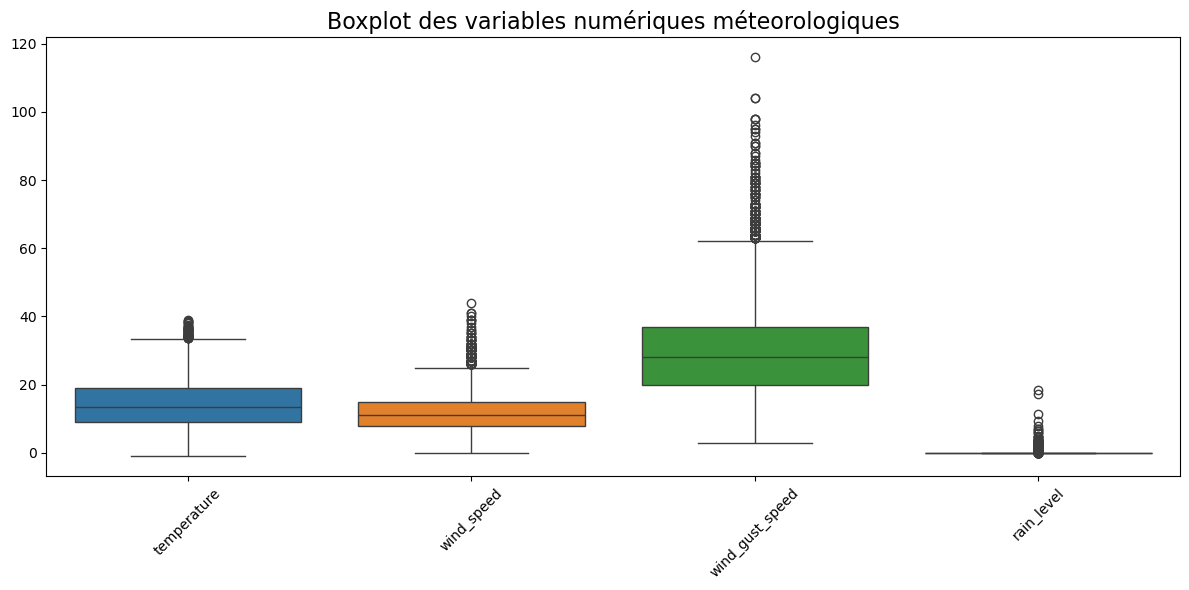

In [113]:

# Sélectionner les colonnes numériques sur la météo
numerical_columns = df_MT.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(['average_flow'])

# Créer une figure avec des sous-graphes (subplots)
plt.figure(figsize=(12, 6))

# Créer un boxplot pour chaque colonne numérique
sns.boxplot(data=df_MT[numerical_columns])

# Ajouter un titre
plt.title("Boxplot des variables numériques méteorologiques", fontsize=16)

# Afficher le graphique
plt.xticks(rotation=45)  # Rotation des labels de colonnes pour plus de lisibilité
plt.tight_layout()  # Ajuste automatiquement l'espacement pour éviter que les éléments se chevauchent
plt.show()

Nous pouvons remarquer que la présence d'outliers est fréquente et pourrait refléter la réalité (comme des vitesses de vent élevées lors de tempêtes). Nous préférons donc conserver ces dernières

Analyse des valeurs unique dans mon jeu de données

In [11]:
print('Les différents états des terminaux présent sont:',pd.unique(df_usage.drop(columns=['timestamp']).values.ravel()))

Les différents états des terminaux présent sont: ['Down' 'Available' 'Passive' 'Offline' 'Charging']


In [114]:
print('les différents états du traffic dans mon jeu de données sont:',df_MT['traffic_state'].unique())

les différents états du traffic dans mon jeu de données sont: ['Fluid' 'Busy' 'Heavy']


In [115]:
df_static.head()

,t_id,s_id,latitude,longitude,street,city,zipcode,model
0,S84-T1,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"E/F, Combo, T2, CHAdeMO, T3"
1,S84-T3,S84,48.863766,2.41177,104 RUE LOUIS LUMIERE,Paris,75020,"CHAdeMO, T2, T3, E/F, Combo"
2,S86-T1,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"CHAdeMO, Combo, T2, T3, E/F"
3,S86-T2,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,E/F
4,S86-T3,S86,48.890610,2.35423,27 RUE ORDENER,Paris,75018,"T3, Combo, CHAdeMO, E/F, T2"


Construction du jeu de données nécessaire pour notre étude

In [116]:
df_real_time.head()

,timestamp,S7-T1,S2-T1,S19-T1,S56-T3,S85-T3,S16-T3,S16-T1,S94-T3,S28-T1,...,S47-T2,S65-T2,S32-T2,S21-T2,S13-T2,S97-T2,S25-T1,S25-T2,S98-T2,S99-T2
7142,2020-02-07T22:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7143,2020-02-07T22:45:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7144,2020-02-07T23:00:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7145,2020-02-07T23:15:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down
7146,2020-02-07T23:30:00+00:00,Down,Available,Available,Available,Down,Available,Passive,Offline,Available,...,Down,Available,Offline,Offline,Offline,Passive,Offline,Offline,Available,Down


In [117]:
df_real_time.shape

(22862, 274)

Construction du dataframe sur l'evolution journalière

In [138]:
# Transformer le DataFrame en format long
df_usage_melted = df_real_time.melt(id_vars=['timestamp'], var_name='t_id', value_name='status')

# Fusionner avec df_static pour obtenir la station (s_id) pour chaque terminal (t_id)
df_usage_with_station = pd.merge(df_usage_melted, df_static, on='t_id')

# Regrouper par timestamp et station, puis compter les occurrences de chaque état
status_counts = df_usage_with_station.groupby(['timestamp', 's_id', 'status']).size().unstack(fill_value=0)

# Réinitialiser l'index pour une meilleure lisibilité
status_counts = status_counts.reset_index()

# Retirer les doublons de s_id afin d'avoir juste la premiére occurence
df_static_s_id = df_static.drop_duplicates(subset=['s_id'])

# Merge 
merged_df = pd.merge(status_counts, df_static_s_id [['s_id', 'latitude', 'longitude', 'zipcode']], on='s_id', how='left')


In [85]:
merged_df.shape


(2080442, 10)

Ajouter la zone géographique

In [17]:
print('Les différents états des terminaux présent sont:',merged_df['zipcode'].unique())

Les différents états des terminaux présent sont: [75004 75020 75016 75014 75009 75015 75012 75018 75019 75010 75017 75013
 75011 75001 75003 75005 75006 75007 75008 75002 75116]


In [139]:
# Creation d'un jeu de données code postal - zone géographiques

postcode_area_data = {
    'zipcode': [75004, 75020, 75016, 75014, 75009, 75015, 75012, 75018, 
                 75019, 75010, 75017, 75013, 75011, 75001, 75003, 75005, 
                 75006, 75007, 75008, 75002, 75116],
    'area': ['South', 'East', 'West', 'South', 'North', 'West', 'East', 'North',
             'East', 'East', 'North', 'South', 'East', 'North', 'North', 'South',
             'South', 'West', 'North', 'North', 'West']
}

postcode_area_df = pd.DataFrame(postcode_area_data)

# Ajouter la zone géographiques à notre daataset
merged_df = pd.merge(merged_df, postcode_area_df, on='zipcode', how='left')

merged_df.head()


,timestamp,s_id,Available,Charging,Down,Offline,Passive,latitude,longitude,zipcode,area
0,2020-02-07T22:30:00+00:00,S1,2,1,0,0,0,48.855667,2.354089,75004,South
1,2020-02-07T22:30:00+00:00,S10,2,0,0,0,1,48.864240,2.397724,75020,East
2,2020-02-07T22:30:00+00:00,S11,2,1,0,0,0,48.861016,2.283080,75016,West
3,2020-02-07T22:30:00+00:00,S12,1,2,0,0,0,48.824388,2.336857,75014,South
4,2020-02-07T22:30:00+00:00,S13,0,0,0,3,0,48.882640,2.335728,75009,North


In [19]:
merged_df.shape

(2080442, 11)

Suppression des données de la période de confinement durant le Covid ( Mars à Mai 2020)

In [120]:

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], utc=True)

# Date de début et de fin du confinement
start_date = pd.to_datetime('2020-03-17 12:00:00', utc=True)
end_date = pd.to_datetime('2021-05-03 23:59:59', utc=True)

# Retirer les données dans cette intervalle de temps
merged_df = merged_df[(merged_df['timestamp'] < start_date) | (merged_df['timestamp'] > end_date)]


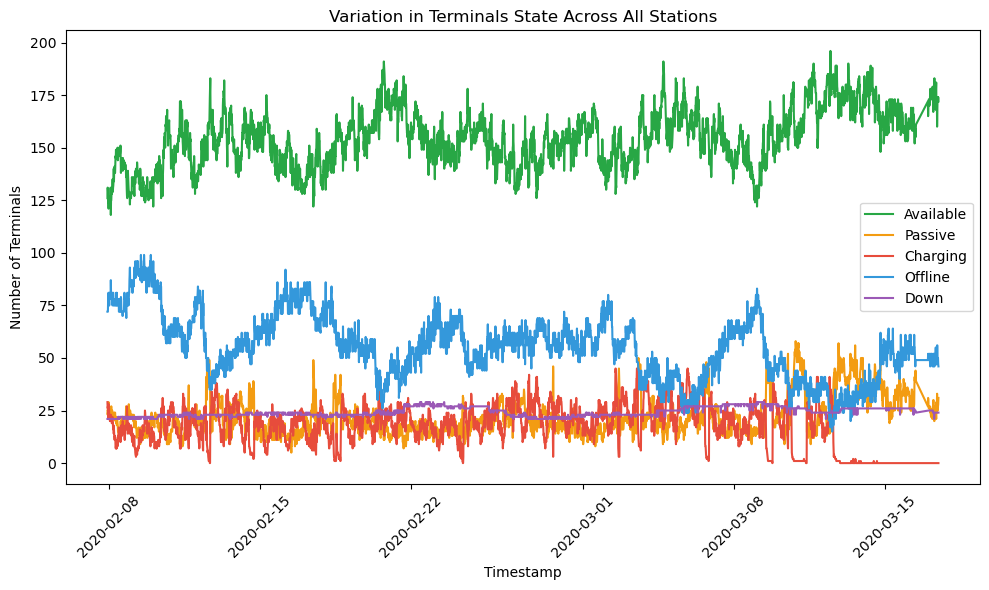

In [121]:

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], utc=True)
# Aggregating the data by timestamp (summing the values of each column)
aggregated_data = merged_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline':'sum'
}).reset_index()

# Plotting the aggregated data
plt.figure(figsize=(10, 6))

# Plot the different states (available, passive, charging)
plt.plot(aggregated_data['timestamp'], aggregated_data['Available'], label='Available', color='#28a745')  # Green
plt.plot(aggregated_data['timestamp'], aggregated_data['Passive'], label='Passive', color='#f39c12')    # Amber
plt.plot(aggregated_data['timestamp'], aggregated_data['Charging'], label='Charging', color='#e74c3c')   # Red
plt.plot(aggregated_data['timestamp'], aggregated_data['Offline'], label='Offline', color='#3498db')     # Blue
plt.plot(aggregated_data['timestamp'], aggregated_data['Down'], label='Down', color='#9b59b6')  


# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State Across All Stations')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Variation pour une station

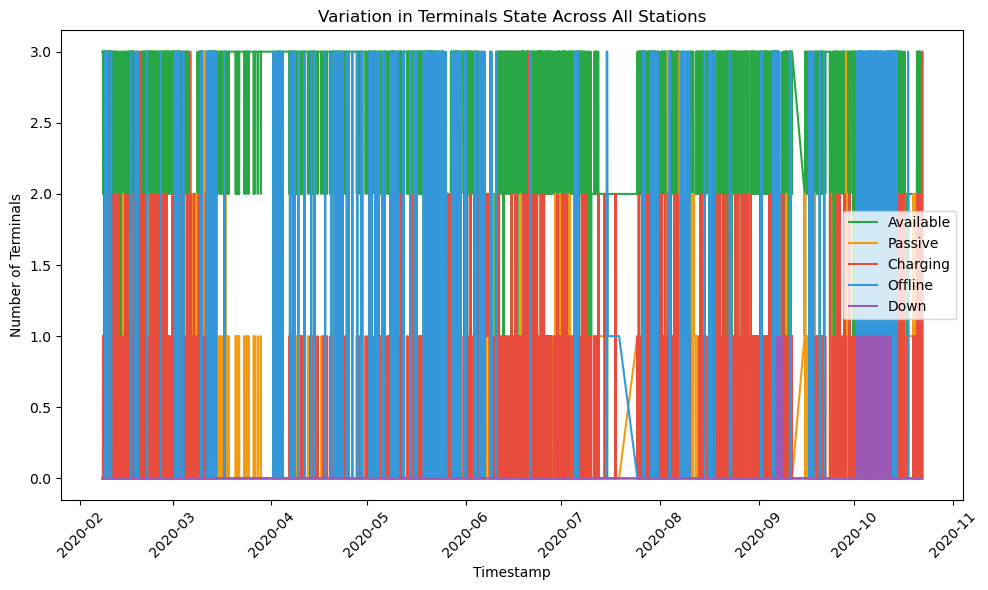

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for 'traffic_state' being 'busy' or 'fluid'
area_df = merged_df[merged_df['s_id'].isin(['S15'])]

# Aggregating the data by timestamp (summing the values of each column)
agg_data = area_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline': 'sum'
}).reset_index()

# Plotting the aggregated data with trendlines
plt.figure(figsize=(10, 6))


# Plot the different states (available, passive, charging)
plt.plot(agg_data['timestamp'], agg_data['Available'], label='Available', color='#28a745')  # Green
plt.plot(agg_data['timestamp'], agg_data['Passive'], label='Passive', color='#f39c12')    # Amber
plt.plot(agg_data['timestamp'], agg_data['Charging'], label='Charging', color='#e74c3c')   # Red
plt.plot(agg_data['timestamp'], agg_data['Offline'], label='Offline', color='#3498db')     # Blue
plt.plot(agg_data['timestamp'], agg_data['Down'], label='Down', color='#9b59b6')  # Purple

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State Across All Stations')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for 'traffic_state' being 'busy' or 'fluid'
South_df = final_df[final_df['area'].isin(['South'])]
North_df = final_df[final_df['area'].isin(['South'])]
East_df = final_df[final_df['area'].isin(['South'])]
South_df = final_df[final_df['area'].isin(['South'])]
South_df = final_df[final_df['area'].isin(['South'])]

# Aggregating the data by timestamp (summing the values of each column)
agg_data = fluid_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline': 'sum'
}).reset_index()

# Plotting the aggregated data with trendlines
plt.figure(figsize=(10, 6))


# Plot the different states (available, passive, charging)
plt.plot(agg_data['timestamp'], agg_data['Available'], label='Available', color='#28a745')  # Green
plt.plot(agg_data['timestamp'], agg_data['Passive'], label='Passive', color='#f39c12')    # Amber
plt.plot(agg_data['timestamp'], agg_data['Charging'], label='Charging', color='#e74c3c')   # Red
plt.plot(agg_data['timestamp'], agg_data['Offline'], label='Offline', color='#3498db')     # Blue
plt.plot(agg_data['timestamp'], agg_data['Down'], label='Down', color='#9b59b6')  # Purple

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State Across All Stations')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for 'traffic_state' being 'Fluid' and 'Busy'
fluid_df = final_df[final_df['traffic_state'] == 'Fluid']
busy_df = final_df[final_df['traffic_state'] == 'Busy']

# Aggregating the data by timestamp (summing the values of each column) for Fluid
agg_data_fluid = fluid_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline': 'sum'
}).reset_index()

# Aggregating the data by timestamp (summing the values of each column) for Busy
agg_data_busy = busy_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline': 'sum'
}).reset_index()

# Plotting the stacked area plot
plt.figure(figsize=(12, 6))


# Plot Busy state as stacked area
plt.stackplot(agg_data_busy['timestamp'], agg_data_busy['Available'], agg_data_busy['Passive'], 
              agg_data_busy['Charging'], agg_data_busy['Down'], agg_data_busy['Offline'], 
              labels=['Available', 'Passive', 'Charging', 'Down', 'Offline'], alpha=0.5)

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State for Fluid and Busy Traffic States (Stacked Area)')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



NameError: name 'final_df' is not defined

In [95]:
fluid_df

,timestamp,s_id,Available,Charging,Down,Offline,Passive,latitude,longitude,zipcode,area,hourly_timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow,traffic_state_encoded


Tester la stationnarité des différents états 

In [15]:
from statsmodels.tsa.stattools import adfuller

# Function to apply ADF test on a series
def adf_test(series, label):
    result = adfuller(series)
    print(f"Résultats du test ADF pour {label}:")
    print(f"Statistique ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critères de test (1%, 5%, 10%): {result[4]}")
    print(f"{'Stationnaire' if result[1] < 0.05 else 'Non stationnaire'}\n")

# Applying ADF test on each column
adf_test(aggregated_data['Available'], 'Available')
adf_test(aggregated_data['Passive'], 'Passive')
adf_test(aggregated_data['Charging'], 'Charging')
adf_test(aggregated_data['Offline'], 'Offline')
adf_test(aggregated_data['Down'], 'Down')

Résultats du test ADF pour Available:
Statistique ADF: -6.217217884125775
p-value: 5.3295810596970896e-08
Critères de test (1%, 5%, 10%): {'1%': np.float64(-3.4309585655439663), '5%': np.float64(-2.8618089518310725), '10%': np.float64(-2.5669131579224924)}
Stationnaire

Résultats du test ADF pour Passive:
Statistique ADF: -9.325046032942396
p-value: 9.661198346422315e-16
Critères de test (1%, 5%, 10%): {'1%': np.float64(-3.430958056257201), '5%': np.float64(-2.86180872677793), '10%': np.float64(-2.5669130381270135)}
Stationnaire

Résultats du test ADF pour Charging:
Statistique ADF: -7.969744070649612
p-value: 2.8020014674942314e-12
Critères de test (1%, 5%, 10%): {'1%': np.float64(-3.4309585655439663), '5%': np.float64(-2.8618089518310725), '10%': np.float64(-2.5669131579224924)}
Stationnaire

Résultats du test ADF pour Offline:
Statistique ADF: -5.764302154118253
p-value: 5.578745174896003e-07
Critères de test (1%, 5%, 10%): {'1%': np.float64(-3.4309585655439663), '5%': np.float64(-2

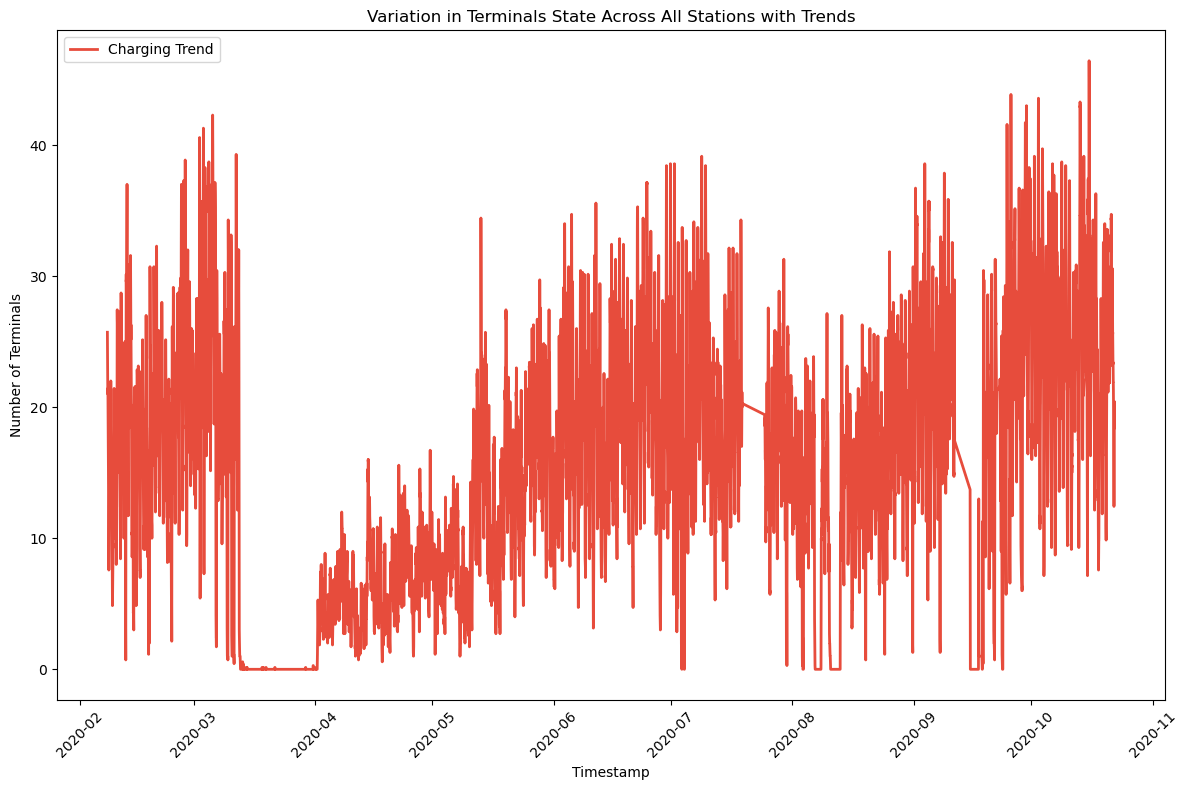

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregating the data by timestamp (summing the values of each column)
aggregated_data = merged_df.groupby('timestamp').agg({
    'Available': 'sum',
    'Passive': 'sum',
    'Charging': 'sum',
    'Down': 'sum',
    'Offline': 'sum'
}).reset_index()

# Calculating rolling averages for trendlines (e.g., 7-point window)
window_size = 7
aggregated_data['Available_Trend'] = aggregated_data['Available'].rolling(window=window_size, center=True).mean()
aggregated_data['Passive_Trend'] = aggregated_data['Passive'].rolling(window=window_size, center=True).mean()
aggregated_data['Charging_Trend'] = aggregated_data['Charging'].rolling(window=window_size, center=True).mean()
aggregated_data['Offline_Trend'] = aggregated_data['Offline'].rolling(window=window_size, center=True).mean()
aggregated_data['Down_Trend'] = aggregated_data['Down'].rolling(window=window_size, center=True).mean()

# Plotting the aggregated data with trendlines
plt.figure(figsize=(12, 8))


# Trendlines

plt.plot(aggregated_data['timestamp'], aggregated_data['Charging_Trend'], label='Charging Trend', color='#e74c3c', linewidth=2)


# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State Across All Stations with Trends')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

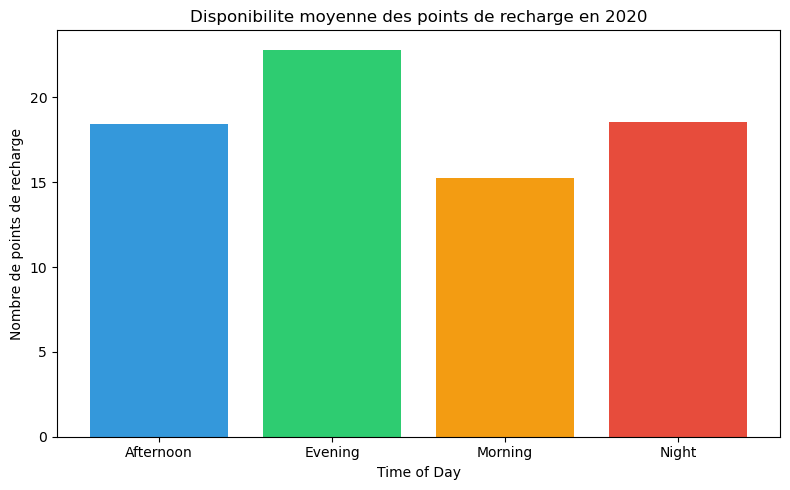

In [17]:
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Extract hour of the day
aggregated_data['hour'] = aggregated_data['timestamp'].dt.hour

aggregated_data['time_of_day'] = aggregated_data['hour'].apply(time_of_day)

# Aggregate availability by time of day
tod_data = aggregated_data.groupby('time_of_day').agg({
    'Available': 'mean',
    'Charging': 'mean'
}).reset_index()

# Bar plot for time-of-day analysis
plt.figure(figsize=(8, 5))
plt.bar(tod_data['time_of_day'], tod_data['Charging'], color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
plt.xlabel('Time of Day')
plt.ylabel('Nombre de points de recharge')
plt.title('Disponibilite moyenne des points de recharge en 2020')
plt.tight_layout()
plt.show()


/tmp/ipykernel_216222/3774207702.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hour', y='Down', data=aggregated_data, palette='Set3')


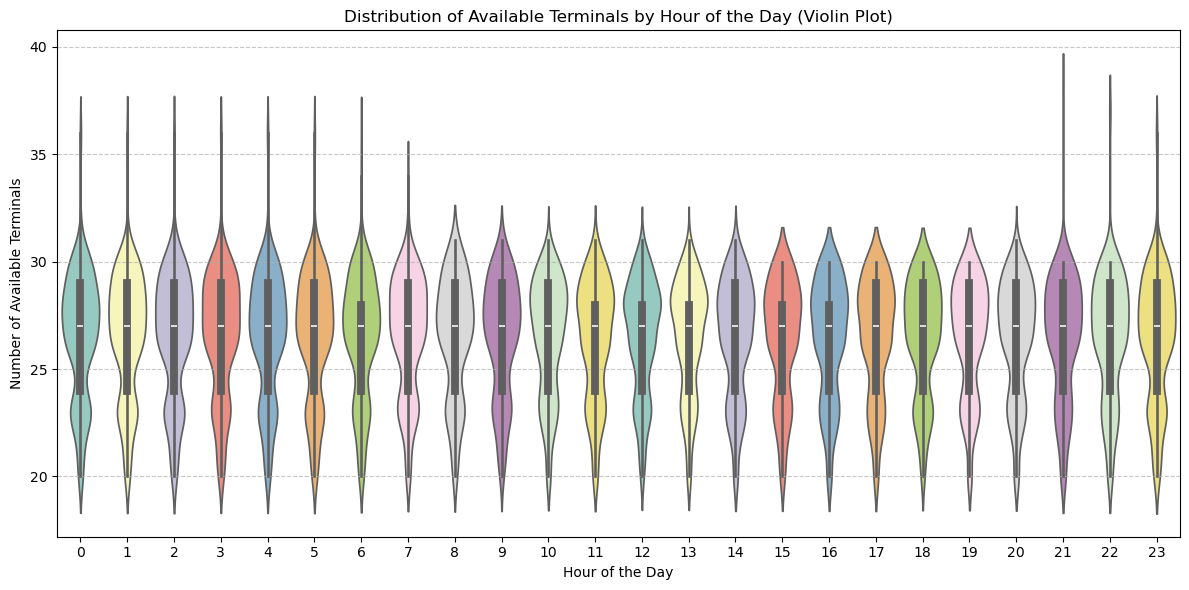

In [18]:
# Violin plot of availability by hour
plt.figure(figsize=(12, 6))
sns.violinplot(x='hour', y='Down', data=aggregated_data, palette='Set3')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Available Terminals')
plt.title('Distribution of Available Terminals by Hour of the Day (Violin Plot)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [89]:
from scipy.stats import pearsonr

# Pearson correlation between hour and available terminals
corr, p_value = pearsonr(aggregated_data['hour'], aggregated_data['Available'])
print(f"Pearson correlation coefficient: {corr:.2f}")
print(f"P-value: {p_value:.4f}")

KeyError: 'hour'

In [102]:
df_MT.head()

,timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2019-11-25 00:00:00,8.7,11.0,24.0,0.0,Fluid,218.1
1,2019-11-25 01:00:00,8.8,9.0,20.0,0.0,Fluid,144.3
2,2019-11-25 02:00:00,8.9,8.0,18.0,0.0,Fluid,110.0
3,2019-11-25 03:00:00,8.8,7.0,18.0,0.0,Fluid,143.8
4,2019-11-25 04:00:00,8.8,10.0,23.0,0.0,Fluid,315.1


In [103]:
merged_df.head()

,timestamp,s_id,Available,Charging,Down,Offline,Passive,latitude,longitude,zipcode,area
0,2020-02-07T22:30:00+00:00,S1,2,1,0,0,0,48.855667,2.354089,75004,South
1,2020-02-07T22:30:00+00:00,S10,2,0,0,0,1,48.864240,2.397724,75020,East
2,2020-02-07T22:30:00+00:00,S11,2,1,0,0,0,48.861016,2.283080,75016,West
3,2020-02-07T22:30:00+00:00,S12,1,2,0,0,0,48.824388,2.336857,75014,South
4,2020-02-07T22:30:00+00:00,S13,0,0,0,3,0,48.882640,2.335728,75009,North


In [140]:
# Ensure both columns are in plain datetime format
df_MT['timestamp'] = pd.to_datetime(df_MT['timestamp']).dt.tz_localize(None)
# Convert the timestamp column to datetime and remove timezone information
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], utc=True).dt.tz_localize(None)
# Floor the timestamp to the nearest hour
merged_df['hourly_timestamp'] = merged_df['timestamp'].dt.floor('H')

# Rename and merge
final_df = pd.merge(
    merged_df,
    df_MT.rename(columns={'timestamp': 'hourly_timestamp'}),
    on='hourly_timestamp',
    how='left'
)

/tmp/ipykernel_216222/3721722716.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged_df['hourly_timestamp'] = merged_df['timestamp'].dt.floor('H')


In [124]:
final_df.head()

,timestamp,s_id,Available,Charging,Down,Offline,Passive,latitude,longitude,zipcode,area,hourly_timestamp,temperature,wind_speed,wind_gust_speed,rain_level,traffic_state,average_flow
0,2020-02-07 22:30:00,S1,2,1,0,0,0,48.855667,2.354089,75004,South,2020-02-07 22:00:00,8.9,9.0,22.0,0.0,Fluid,715.1
1,2020-02-07 22:30:00,S10,2,0,0,0,1,48.864240,2.397724,75020,East,2020-02-07 22:00:00,8.9,9.0,22.0,0.0,Fluid,715.1
2,2020-02-07 22:30:00,S11,2,1,0,0,0,48.861016,2.283080,75016,West,2020-02-07 22:00:00,8.9,9.0,22.0,0.0,Fluid,715.1
3,2020-02-07 22:30:00,S12,1,2,0,0,0,48.824388,2.336857,75014,South,2020-02-07 22:00:00,8.9,9.0,22.0,0.0,Fluid,715.1
4,2020-02-07 22:30:00,S13,0,0,0,3,0,48.882640,2.335728,75009,North,2020-02-07 22:00:00,8.9,9.0,22.0,0.0,Fluid,715.1


In [125]:
final_df.shape

(331695, 18)

                 Available  Charging      Down   Offline   Passive
temperature       0.025387  0.015038  0.000398 -0.030312 -0.008467
wind_speed       -0.016663  0.025295  0.000595  0.002103  0.013691
wind_gust_speed  -0.017599  0.034108  0.000741 -0.000233  0.013238
rain_level        0.001024  0.004691 -0.001146 -0.001303 -0.001948
average_flow     -0.041107  0.098935  0.000464 -0.010925  0.039837


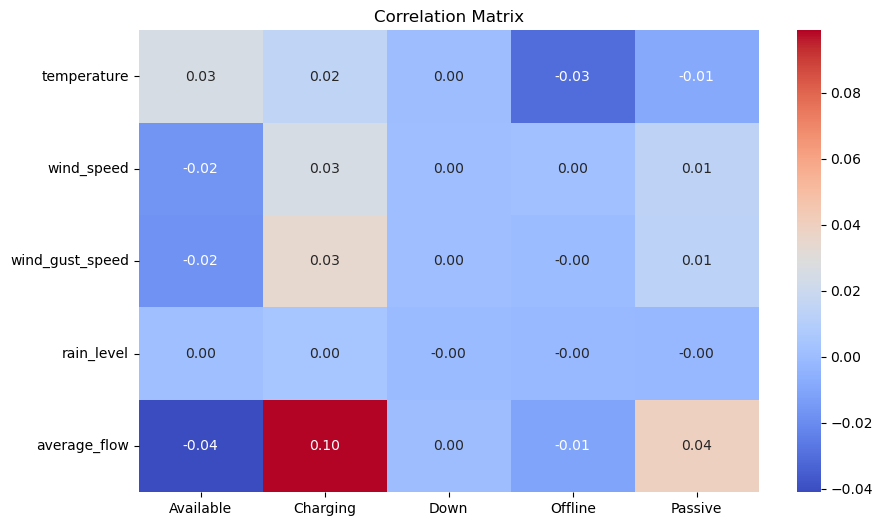

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify variables of interest for the analysis
x_axis_vars = ['Available', 'Charging', 'Down', 'Offline', 'Passive']
y_axis_vars = [
    'temperature', 'wind_speed', 'wind_gust_speed',
    'rain_level', 'average_flow'
]

# Combine x-axis and y-axis variables for subset selection
variables_of_interest = x_axis_vars + y_axis_vars

# Subset the DataFrame
final_df_subset = final_df[variables_of_interest]

# Compute the correlation matrix
correlation_matrix = final_df_subset.corr()

# Extract the correlations: rows = y_axis_vars, columns = x_axis_vars
correlation_matrix_subset = correlation_matrix.loc[y_axis_vars, x_axis_vars]

# Display the correlation matrix
print(correlation_matrix_subset)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix_subset,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()


In [142]:
unique_traffic_states = df_MT['traffic_state'].unique()
print(unique_traffic_states)

['Fluid' 'Busy' 'Heavy']


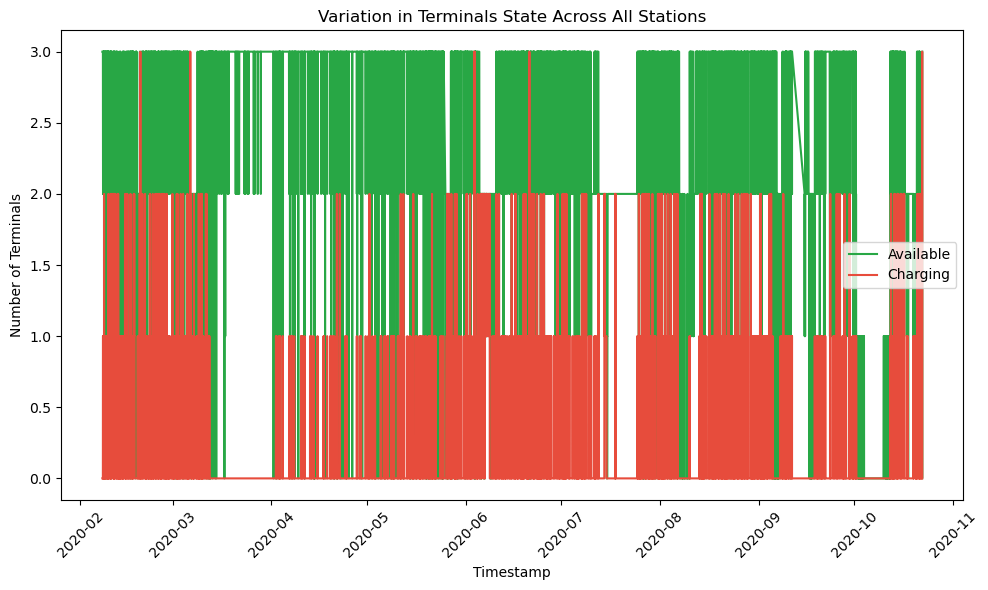

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for the specific station ID 'S15'
one_station = final_df[final_df['s_id'].isin(['S15'])]

# Optional: Filter for only "fluid" traffic states at station 'S15'
one_station_fluid = one_station[one_station['traffic_state'] == 'Fluid']

# Aggregating the data by timestamp (summing the values of each column)
agg_data = one_station.groupby('timestamp').agg({
    'Available': 'sum',
    'Charging': 'sum'
}).reset_index()

# Plotting the aggregated data with trendlines
plt.figure(figsize=(10, 6))


# Plot the different states (available, passive, charging)
plt.plot(agg_data['timestamp'], agg_data['Available'], label='Available', color='#28a745')  # Green
plt.plot(agg_data['timestamp'], agg_data['Charging'], label='Charging', color='#e74c3c')   # Red


# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Terminals')
plt.title('Variation in Terminals State Across All Stations')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
